## TF Binding Prediction Analysis

### Inhyeok Daniel Lee

### April 18 2025

This notebook analyzes the results of my trained CNN model designed to predict Homer TF binding scores from DNA sequences.

This model is mainly inspired by two milestone CNN models:

1) VGGNet (VGG stands for Visual Geometry Group) in 2014

    * Stacking filter of size 3 could incrementally capture larger receptive fields (stack of 2 -> 5, 3 -> 7, ...)

    * Adding more convolutional layers introduce more non-linearity, which aids complex feature representation within the float32 scale.

    * Stacking small filters is incredibly economical compared to using one big filter.

    * Stacking small filters introduce hierarchical feature learning from low-level to high-level.

2) ResNet in 2015

    * Approximating the residual between inputs and feature mapping is more beneficial than approximating the native feature mapping due to better gradient flow (gradient flows better near 0).

    * Learning residuals every 2 convolutional layer is shown to be performing best by empirical studies (every 3 convolutional layer for much deeper architecture).

        Learning residuals every convolutional layer may perform undesirably because they may impede complex feature representation.

References

VGGNet: https://arxiv.org/abs/1409.1556 \
ResNet: https://arxiv.org/abs/1512.03385

## 1. Imports and Setup

In [31]:
import os
import gzip
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import random
from IPython.display import Image, display

## 2. Configuration

In [32]:
DATA_DIR = '../data'
SEQ_FILE = os.path.join(DATA_DIR, 'chr22_sequences.txt.gz')
SCORE_FILE = os.path.join(DATA_DIR, 'chr22_scores.txt.gz')
MODEL_WEIGHTS_FILE = 'lee-inhyeok-model.pth'
TRAINING_HISTORY_IMG = '../training_history.png'
EXAMPLE_PREDICTION_IMG = '../example_prediction.png'
NUM_PLOT_SAMPLES = 5

## 3. Helper Functions

In [33]:
def one_hot_encode(sequence):
    mapping = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    seq_len = len(sequence)
    encoded = torch.zeros((4, seq_len), dtype=torch.float32)
    for i, base in enumerate(sequence.upper()):
        idx = mapping.get(base, -1) 
        if idx != -1:
            encoded[idx, i] = 1.0
    return encoded

def calculate_pearsonr(preds, targets):
    if isinstance(preds, torch.Tensor):
        preds = preds.detach().cpu().numpy()
    if isinstance(targets, torch.Tensor):
        targets = targets.detach().cpu().numpy()
        
    preds_flat = preds.flatten()
    targets_flat = targets.flatten()

    valid_indices = np.isfinite(preds_flat) & np.isfinite(targets_flat)
    preds_flat = preds_flat[valid_indices]
    targets_flat = targets_flat[valid_indices]

    if len(preds_flat) < 2:
        print("Warning: Not enough valid data points to calculate Pearson R.")
        return 0.0

    try:
        r, _ = pearsonr(preds_flat, targets_flat)
        return r if np.isfinite(r) else 0.0
    except ValueError:
        print("Warning: ValueError during Pearson R calculation.")
        return 0.0

def plot_comparison(pred, obs, title="Comparison", save_path=None):
    if isinstance(pred, torch.Tensor):
         pred = pred.detach().cpu().numpy()
    if isinstance(obs, torch.Tensor):
         obs = obs.detach().cpu().numpy()
         
    r_value = calculate_pearsonr(pred, obs)
    x = np.arange(len(pred))
    bar_width = 0.4
    plt.figure(figsize=(12, 5))
    plt.bar(x - bar_width/2, pred, width=bar_width, label="Predicted", alpha=0.7, color='b')
    plt.bar(x + bar_width/2, obs, width=bar_width, label="Observed", alpha=0.7, color='r')
    plt.xlabel("Position in sequence window")
    plt.ylabel("Homer Score")
    plt.title(f"{title}\nPearson R: {r_value:.3f}")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    if save_path:
        plt.savefig(save_path)
        print(f"Plot saved to {save_path}")
        plt.close()
    else:
        plt.show()

## 4. Data Loading

In [34]:
print("Loading data...")
sequences_df = None
scores_df = None
data_loaded_successfully = False
try:
    sequences_df = pd.read_csv(SEQ_FILE, sep="\t", compression='gzip')
    scores_df = pd.read_csv(SCORE_FILE, sep="\t", compression='gzip')
    print(f"Loaded {len(sequences_df)} sequences and {len(scores_df.columns)} score vectors.")
    
    if len(sequences_df) != len(scores_df.columns):
        print(f"Warning: Number of sequences ({len(sequences_df)}) does not match number of score columns ({len(scores_df.columns)}). Ensure they correspond correctly.")
        min_len = min(len(sequences_df), len(scores_df.columns))
        sequences_df = sequences_df.iloc[:min_len]
        scores_df = scores_df.iloc[:, :min_len]
        print(f"Proceeding with {min_len} sequence/score pairs.")
    elif 'sequence' not in sequences_df.columns:
         print("Warning: 'sequence' column not found in sequences file.")
         raise ValueError("'sequence' column missing from sequence file.")
    else:
        data_loaded_successfully = True
        
except FileNotFoundError:
    print(f"Error: Data files not found. Ensure '{SEQ_FILE}' and '{SCORE_FILE}' exist in the '{DATA_DIR}' directory relative to where you run the notebook.")
except Exception as e:
    print(f"Error loading or processing data: {e}")

if data_loaded_successfully:
    print("Data loaded successfully.")
    print("Sequences DataFrame head:")
    display(sequences_df.head())
    print("Scores DataFrame head:")
    display(scores_df.head())
else:
    print("Data loading failed. Cannot proceed with analysis.")

Loading data...
Loaded 23139 sequences and 23139 score vectors.
Data loaded successfully.
Sequences DataFrame head:


,sequence,window_name
0,GCAAGACTCAGTCTCAAGGAAAAAAAAAAGCTCGAAAAATGTTTGC...,chr22_10510500_10510799
1,AATCAAAAAGAATATTAGAAAACAAGCTGACAAAAAAATAAAAAAA...,chr22_10512900_10513199
2,AGAAAAAGATATAAAGGCATCCAAATTGGAAAGGAAGAAGTAAGTA...,chr22_10514100_10514399
3,CAAATGGATTGAAGACTTAAATGTAAGAACTAAAGCTGTAAAACTA...,chr22_10515300_10515599
4,AAAATAGACCTACCATATGATGCAGCAATCCCACTTGTGGGCATTT...,chr22_10515900_10516199


Scores DataFrame head:


,chr22_10510500_10510799,chr22_10512900_10513199,chr22_10514100_10514399,chr22_10515300_10515599,chr22_10515900_10516199,chr22_10518900_10519199,chr22_10521600_10521899,chr22_10521900_10522199,chr22_10522500_10522799,chr22_10523100_10523399,...,chr22_50796900_50797199,chr22_50797500_50797799,chr22_50798100_50798399,chr22_50798400_50798699,chr22_50798700_50798999,chr22_50799300_50799599,chr22_50801700_50801999,chr22_50803800_50804099,chr22_50805000_50805299,chr22_50806800_50807099
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 5. Model Definition

In [35]:
# Model architecture is loaded directly from the TorchScript file.

## 6. Load Pre-trained Model

In [36]:
model = None
model_loaded_successfully = False
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device (Apple Silicon GPU).")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA device.")
else:
    device = torch.device("cpu")
    print("Using CPU device.")

try:
    print(f"Attempting to load model from: {MODEL_WEIGHTS_FILE}")
    model = torch.jit.load(MODEL_WEIGHTS_FILE, map_location=device)
    model.to(device)
    model.eval()
    print(f"Successfully loaded TorchScript model.")
    model_loaded_successfully = True
except FileNotFoundError:
    print(f"Error: Model file not found at '{MODEL_WEIGHTS_FILE}'. Ensure the path is correct relative to where you run the notebook.")
except Exception as e:
    print(f"Error loading TorchScript model: {e}")

if model_loaded_successfully:
    print("\nLoaded Model Structure:")
    print(model)
else:
    print("Model loading failed. Cannot proceed with analysis.")

Using MPS device (Apple Silicon GPU).
Attempting to load model from: lee-inhyeok-model.pth
Successfully loaded TorchScript model.

Loaded Model Structure:
RecursiveScriptModule(
  original_name=BindingPredictorCNN
  (initial_conv): RecursiveScriptModule(original_name=Conv1d)
  (initial_norm): RecursiveScriptModule(original_name=LayerNorm)
  (initial_relu): RecursiveScriptModule(original_name=ReLU)
  (res_blocks): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(
      original_name=ResidualBlock
      (conv1): RecursiveScriptModule(original_name=Conv1d)
      (norm1): RecursiveScriptModule(original_name=LayerNorm)
      (relu1): RecursiveScriptModule(original_name=ReLU)
      (dropout): RecursiveScriptModule(original_name=Dropout)
      (conv2): RecursiveScriptModule(original_name=Conv1d)
      (norm2): RecursiveScriptModule(original_name=LayerNorm)
      (relu2): RecursiveScriptModule(original_name=ReLU)
    )
    (1): RecursiveScriptModule(
      ori

## 7. Display Training Results

Displaying saved training history plot:
Loading image from: ../training_history.png


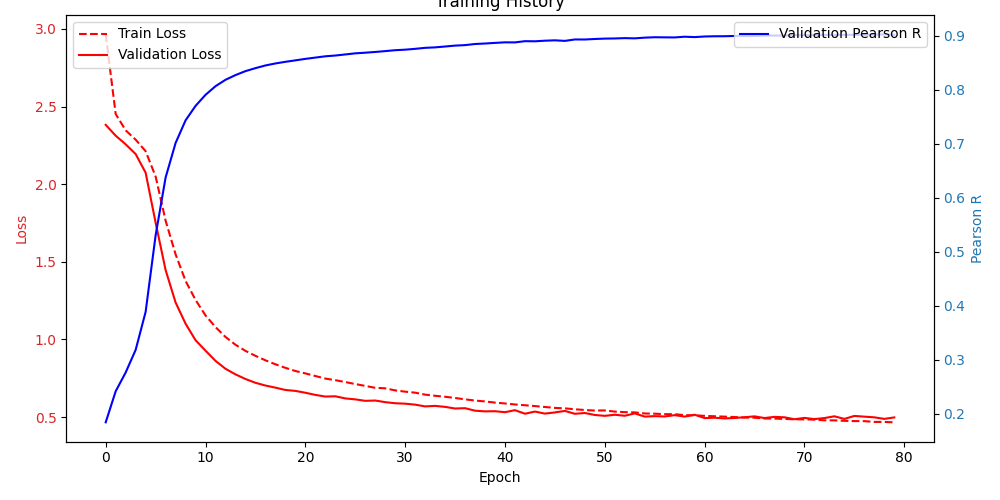

In [37]:
print("Displaying saved training history plot:")
if os.path.exists(TRAINING_HISTORY_IMG):
    print(f"Loading image from: {TRAINING_HISTORY_IMG}")
    display(Image(filename=TRAINING_HISTORY_IMG))
else:
    print(f"Warning: Training history image '{TRAINING_HISTORY_IMG}' not found.")

## 8. Inference on Random Samples


Performing inference and plotting 5 random samples...
Selected random indices: [22985, 18432, 8668, 8722, 404]


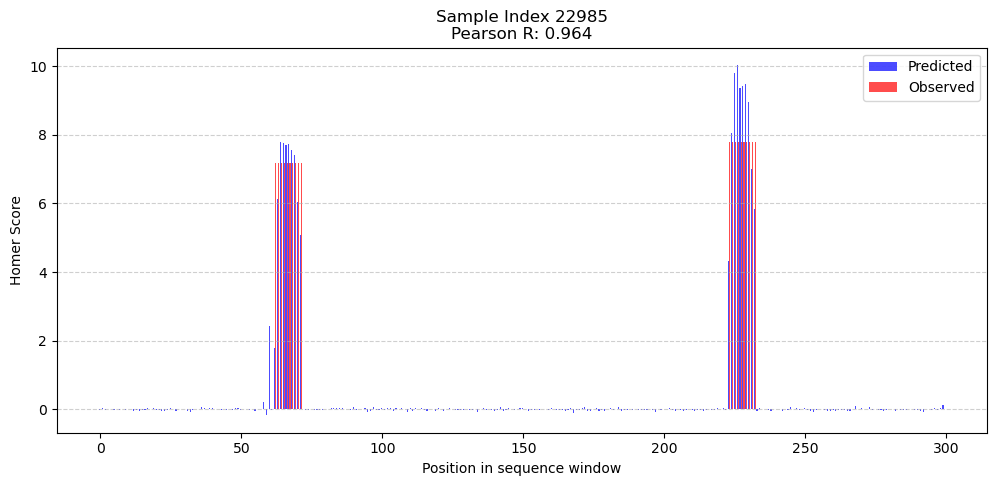

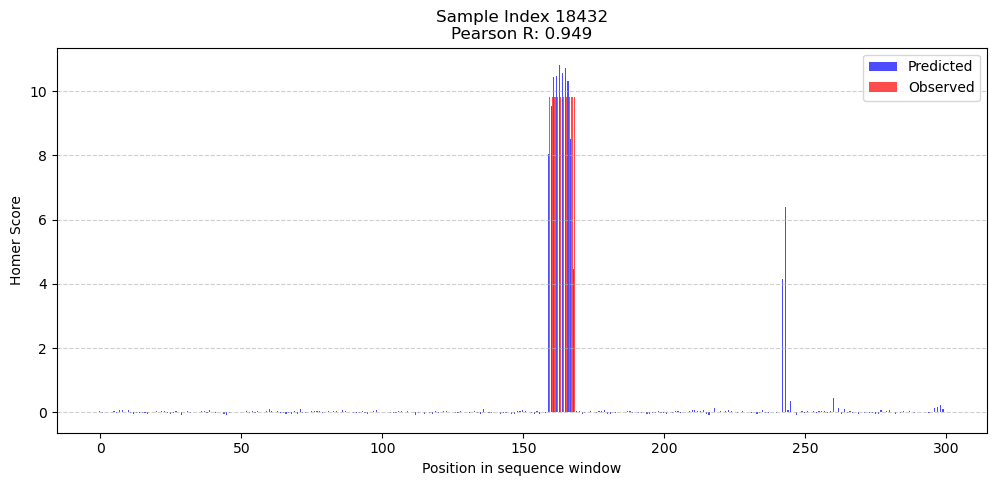

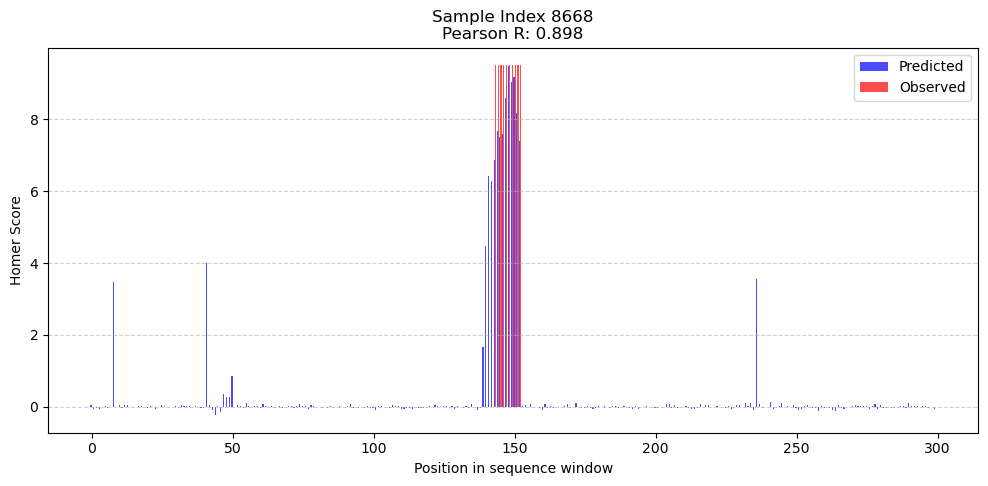

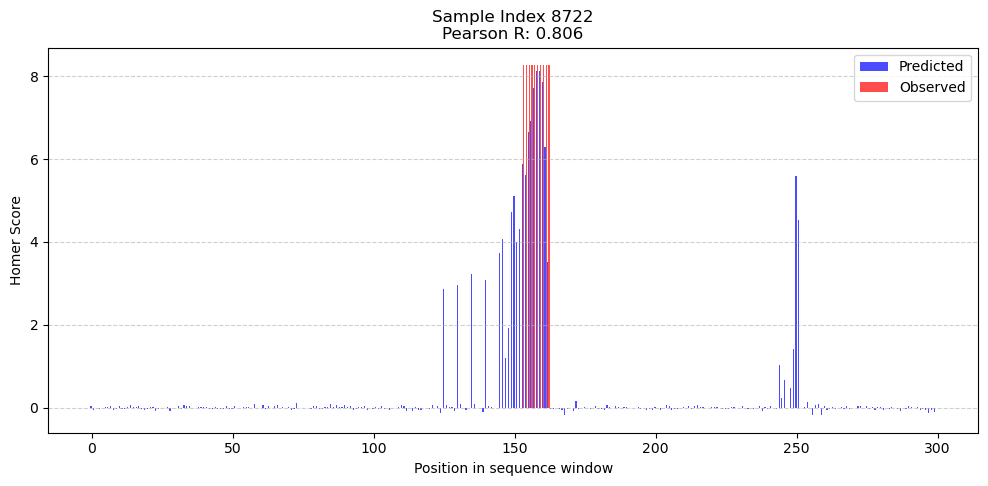

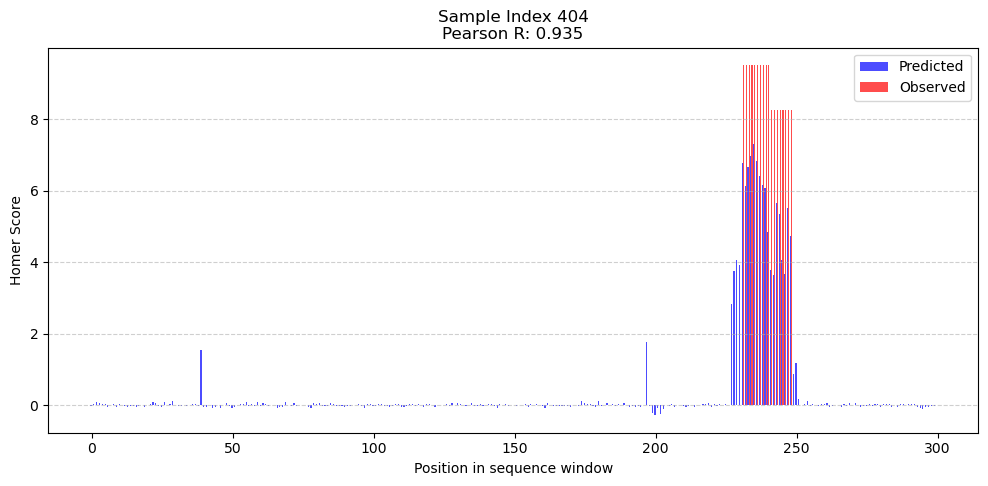

In [38]:
if data_loaded_successfully and model_loaded_successfully:
    print(f"\nPerforming inference and plotting {NUM_PLOT_SAMPLES} random samples...")
    
    num_available_samples = len(sequences_df)
    if num_available_samples == 0:
        print("Error: No sequences available to perform inference on.")
    else:
        num_to_plot = min(NUM_PLOT_SAMPLES, num_available_samples)
        random_indices = random.sample(range(num_available_samples), num_to_plot)
        print(f"Selected random indices: {random_indices}")
        
        for i in random_indices:
            try:
                sequence = sequences_df.iloc[i]['sequence']
                observed_scores = torch.tensor(scores_df.iloc[:, i].values, dtype=torch.float32) # Get score column by index i
                
                input_tensor = one_hot_encode(sequence)
                input_tensor = input_tensor.unsqueeze(0)
                input_tensor = input_tensor.to(device)
                
                with torch.no_grad():
                    predicted_scores_tensor = model(input_tensor)
                
                predicted_scores = predicted_scores_tensor.squeeze(0).cpu()
                
                if predicted_scores.shape != observed_scores.shape:
                     print(f"Warning: Shape mismatch for sample {i}. Predicted: {predicted_scores.shape}, Observed: {observed_scores.shape}. Skipping plot.")
                     continue
                     
                plot_title = f"Sample Index {i}"
                plot_comparison(predicted_scores, observed_scores, title=plot_title)
                
            except IndexError:
                 print(f"Error: Score column index {i} out of bounds for scores_df with {len(scores_df.columns)} columns. Check data consistency.")
            except Exception as e:
                print(f"Error processing sample index {i}: {e}")
                
else:
    print("\nSkipping inference because data or model failed to load.")

## 9. Summary

This notebook demonstrates loading the pre-trained TF binding prediction model, loading the sequence and score data, visualizing the training history (if available), and performing inference on random samples from the data. It plots the predicted scores against the observed scores for visual comparison and calculates the Pearson correlation coefficient for each sample.